## Pneumonia Identification - A Neural Network Model

### Pneumonia infection 
Pneumonia is a common acute respiratory infectiom that affects the alveoli and distal airways. It is associated with high morbidity and is a major health problem with both short term and long term affects. Pneumonia is also widespread occuring in all parts of the globe across all age groups. It is more common in the very young (< 5 years of age) and older adults, particularly amonsgt those who suffer from other health conditions. Nearly one million children per year lose their lives to pneumonia and related causes. The causes of pneumonia have multiple vectors - viral, bacterial, and fungal. Individuals with pneumonia face both respiratory and systemic symptoms. Accurate diagnosis of the infection requires both clinical and radiological (x-ray) methods. Rapid and accurate diagnosis is also crucial to successful treatment, often with a range of antimicrobial therapies. Rapid imaging assessment is a matter of life and death.

#### Business Case - Intermountain Health Care
Intermountain Health Care (IHC) is a not-for-profit healthcare system based in Utah. Over the past several years they have been working to extend their reach to rural areas. IHC now operates nine hospitals and 23 rural community medical clinics. Despite their reach they face a shortage of medical specialists, particularly radiologists. According to the American Medical     There is a looming shortage of trained radiologists

In [83]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os, shutil
from PIL import Image
import scipy
from scipy import ndimage

# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(123)

## Load Data 

In [84]:
train = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train', labels = 'inferred', 
                                                            class_names = ['NORMAL', 'PNEUMONIA'])

Found 5216 files belonging to 2 classes.


In [85]:
test = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/test', labels = 'inferred',
                                                          class_names = ['NORMAL', 'PNEUMONIA'])

Found 624 files belonging to 2 classes.


In [86]:
val = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/val', labels = 'inferred',
                                                         class_names = ['NORMAL', 'PNEUMONIA'])

Found 16 files belonging to 2 classes.


Pediatric Lung Image - NORMAL


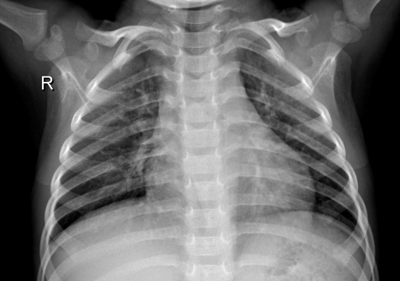

Pediatric Lung Image - PNEUMONIA (viral origins)


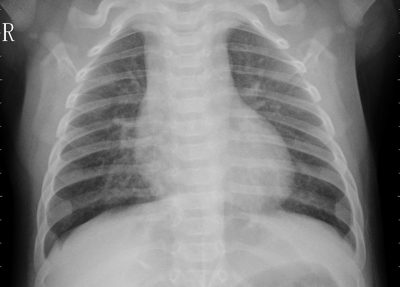

Pediatric Lung Image - PNEUMONIA (bacterial origins)


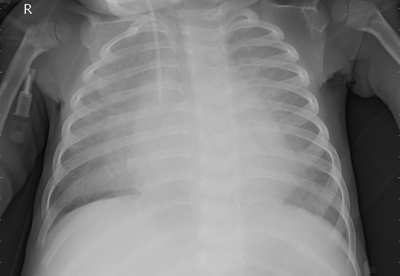

In [87]:
#Display normal lung image

print('Pediatric Lung Image - NORMAL')

norm_img = Image.open('chest_xray/train/NORMAL/IM-0125-0001.jpeg')
norm_img.thumbnail((400, 400))
display(norm_img);

# Display pneumonia image with viral origins

print('Pediatric Lung Image - PNEUMONIA (viral origins)')

p_img = Image.open('chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')
p_img.thumbnail((400, 400))
display(p_img);

# Display pneumonia image with bacterial origins

print('Pediatric Lung Image - PNEUMONIA (bacterial origins)')

p_img = Image.open('chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg')
p_img.thumbnail((400, 400))
display(p_img);


## Process the datasets for modeling

In [88]:
# Identify shape of each dataset
print('Shape and Datatype of Train dataset:', train)
print()
print('Shape and Datatype of Val dataset:', val)
print()
print('Shape and Datatype of Test dataset:', test)

Shape and Datatype of Train dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Shape and Datatype of Val dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Shape and Datatype of Test dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [89]:
# plot histogram showing classes - normal and pneumonia



In [90]:
#identify file path
train_folder = 'chest_xray/train'
val_folder = 'chest_xray/val'
test_folder = 'chest_xray/test'

In [91]:
# get all the data in the directory, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 624) 

# get all the data in the directory, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 16)

# get all the data in the directory, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size = 5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [92]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [93]:
#reshape for deep learning
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 12288)
(624, 12288)
(16, 12288)


In [95]:
#reshape labels
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

## 1. Build a baseline model

Build a simple baseline model using densely connected layers. 

In [121]:
# Neural network model
baseline_model = Sequential()

# No hidden layers

#Input
baseline_model.add(Dense(16, activation='relu', input_shape=(12288,))) 

# Binary output
baseline_model.add(Dense(1, activation='sigmoid'))

In [134]:
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

base_history = baseline_model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    #validation_data = (val_img, val_y))
                    validation_split = 0.2)

Epoch 1/30
131/131 [==============================] - 0s 2ms/step - loss: 0.1152 - accuracy: 0.9578 - val_loss: 0.0879 - val_accuracy: 0.9646
Epoch 2/30
131/131 [==============================] - 0s 1ms/step - loss: 0.1121 - accuracy: 0.9559 - val_loss: 0.0911 - val_accuracy: 0.9665
Epoch 3/30
131/131 [==============================] - 0s 1ms/step - loss: 0.1144 - accuracy: 0.9561 - val_loss: 0.1733 - val_accuracy: 0.9349
Epoch 4/30
131/131 [==============================] - 0s 1ms/step - loss: 0.1131 - accuracy: 0.9578 - val_loss: 0.0868 - val_accuracy: 0.9665
Epoch 5/30
131/131 [==============================] - 0s 1ms/step - loss: 0.1192 - accuracy: 0.9559 - val_loss: 0.1220 - val_accuracy: 0.9540
Epoch 6/30
131/131 [==============================] - 0s 1ms/step - loss: 0.1073 - accuracy: 0.9597 - val_loss: 0.4223 - val_accuracy: 0.8257
Epoch 7/30
131/131 [==============================] - 0s 1ms/step - loss: 0.1196 - accuracy: 0.9571 - val_loss: 0.1470 - val_accuracy: 0.9444
Epoch 

In [135]:
# Baseline training results
base_results_train = baseline_model.evaluate(train_img, train_y)

163/163 [==============================] - 0s 1ms/step - loss: 0.0835 - accuracy: 0.9676


In [136]:
base_results_test = baseline_model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 1ms/step - loss: 1.1914 - accuracy: 0.7244


In [137]:
#Print results for train and test
print("Baseline Results from Training Data:", base_results_train)
print()
print("Baseline Results from Test Data:", base_results_test)



Baseline Results from Training Data: [0.08350731432437897, 0.9675996899604797]

Baseline Results from Test Data: [1.1914342641830444, 0.7243589758872986]


In [138]:
# Plot train and test loss and accuracy
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

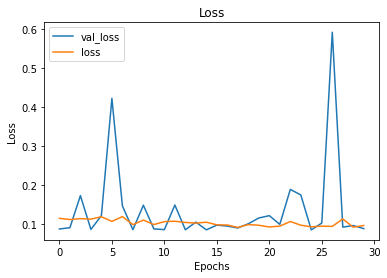

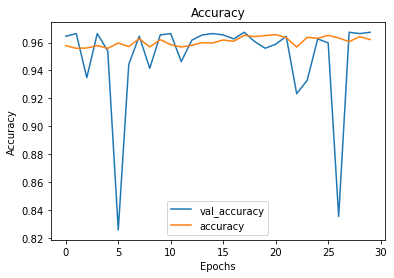

In [139]:
visualize_training_results(base_history)

#### Model Evaluation

What is going on here most likely?

## CNN Model - First Iteration

Include convolution, and 2 hidden layers.

In [147]:
#Instantiate a CNN model

model_1 = Sequential()

# Add convolution layer

model_1.add(Conv2D(32, (3, 3), activation = 'relu',
                   input_shape = (64, 64, 3)))


# Add another convolution layer

model_1.add(Conv2D(64, (3, 3), activation='relu'))


# Flatten the model

model_1.add(Flatten())

# Add dense layers, two hidden

model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(7, activation = 'relu'))
model_1.add(Dense(5, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and rmsprop for optimizer

model_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [148]:
# Examine the built model
model_1.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
flatten_13 (Flatten)         (None, 230400)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)                14745664  
_________________________________________________________________
dense_62 (Dense)             (None, 7)                 455       
_________________________________________________________________
dense_63 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_64 (Dense)             (None, 1)               

In [149]:
# Fit the model
history_1 = model_1.fit(train_images, 
                        train_y, 
                        epochs=20, 
                        #validation_data=(val_images, val_y))
                        validation_split = 0.2) 
                                

Epoch 1/20
131/131 [==============================] - 32s 246ms/step - loss: 0.5324 - accuracy: 0.7960 - val_loss: 0.1344 - val_accuracy: 0.9607
Epoch 2/20
131/131 [==============================] - 31s 238ms/step - loss: 0.1873 - accuracy: 0.9307 - val_loss: 0.0961 - val_accuracy: 0.9636
Epoch 3/20
131/131 [==============================] - 32s 241ms/step - loss: 0.1348 - accuracy: 0.9542 - val_loss: 0.0961 - val_accuracy: 0.9684
Epoch 4/20
131/131 [==============================] - 31s 237ms/step - loss: 0.1053 - accuracy: 0.9636 - val_loss: 0.1512 - val_accuracy: 0.9483
Epoch 5/20
131/131 [==============================] - 31s 235ms/step - loss: 0.1154 - accuracy: 0.9662 - val_loss: 0.2515 - val_accuracy: 0.9138
Epoch 6/20
131/131 [==============================] - 30s 225ms/step - loss: 0.0876 - accuracy: 0.9760 - val_loss: 0.1252 - val_accuracy: 0.9626
Epoch 7/20
131/131 [==============================] - 29s 221ms/step - loss: 0.0938 - accuracy: 0.9794 - val_loss: 0.0800 - val_ac

In [27]:
results_1_train = model_1.evaluate(train_images, train_y)

163/163 [==============================] - 2s 11ms/step - loss: 0.0591 - accuracy: 0.9893


In [28]:
results_1_test = model_1.evaluate(test_images, test_y)

20/20 [==============================] - 0s 10ms/step - loss: 2.1021 - accuracy: 0.7436


In [29]:
#Print results for Model 1 train and test
print("Model 1 Results from Training Data:", results_1_train)
print()
print("Model 1 Results from Test Data:", results_1_test)



Model 1 Results from Training Data: [0.05914289131760597, 0.9892638325691223]

Model 1 Results from Test Data: [2.1020612716674805, 0.7435897588729858]


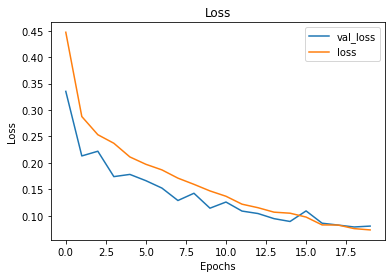

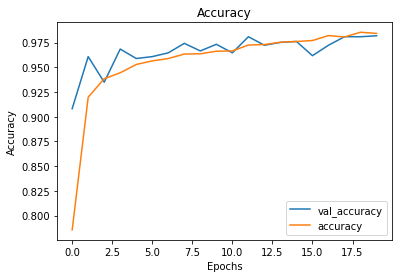

In [30]:
# Plot accuracy and loss
visualize_training_results(history_1)

#### Model Evaluation

What is going on here most likely?

## 2.  Data Augmentation 
Add data augmentation to account for imbalance classes. Include Maxpooling. 

In [150]:
# Check class imbalance in train

# How do I do this?


In [222]:
# Augment the training data to account for class imbalance
train_datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=20, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.1, 
                             horizontal_flip=True, 
                             validation_split = 0.2)

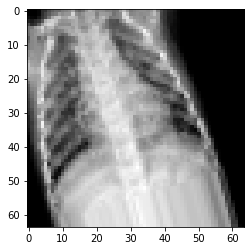

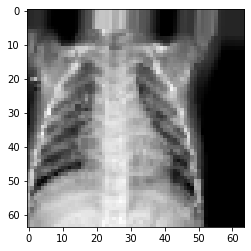

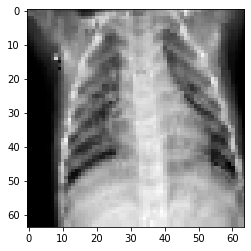

In [223]:
# View an augmented image

# Load image
img = load_img('chest_xray/train/NORMAL/IM-0125-0001.jpeg', target_size=(64, 64))

# Reshape
reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 

# Run image through augmented image generator

i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
        
plt.show()

In [224]:
# 
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), 
        batch_size = 32,
        class_mode='binary') 

# 
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64),
        batch_size = 32,
        class_mode='binary')

# 
train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        batch_size = 32, 
        class_mode='binary')

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [225]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [226]:
train_labels.shape

(32,)

In [227]:
train_images.shape

(32, 64, 64, 3)

In [228]:
#reshape labels
#train_y = np.reshape(train_labels[:,0], (5216,1))
#test_y = np.reshape(test_labels[:,0], (624,1))
#val_y = np.reshape(val_labels[:,0], (16,1))

In [229]:
#Instantiate a CNN model

model_2 = Sequential()

# Add convolution layer

model_2.add(Conv2D(32, (3, 3), activation = 'relu',
                   input_shape= (64, 64, 3)))

# Add a maxpooling layer

model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolution layer

model_2.add(Conv2D(32, (4, 4), activation='relu'))

# Add another maxpooling layer

model_2.add(MaxPooling2D((2, 2)))

# Flatten the model

model_2.add(Flatten())

# Add dense layers

model_2.add(Dense(128, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and rmsprop for optimizer

model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [230]:
model_2.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_91 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_92 (Dense)             (None, 1)               

In [231]:
history_2 = model_2.fit(train_generator,  
                      epochs=20, 
                      validation_data=val_generator,
                      verbose = 1)

Epoch 1/20
163/163 [==============================] - 66s 402ms/step - loss: 0.5707 - accuracy: 0.7345 - val_loss: 0.6285 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 67s 410ms/step - loss: 0.4473 - accuracy: 0.7941 - val_loss: 0.7635 - val_accuracy: 0.6875
Epoch 3/20
163/163 [==============================] - 66s 406ms/step - loss: 0.3591 - accuracy: 0.8476 - val_loss: 0.6129 - val_accuracy: 0.6875
Epoch 4/20
163/163 [==============================] - 67s 408ms/step - loss: 0.3098 - accuracy: 0.8681 - val_loss: 0.8382 - val_accuracy: 0.6875
Epoch 5/20
163/163 [==============================] - 65s 398ms/step - loss: 0.2901 - accuracy: 0.8762 - val_loss: 0.5052 - val_accuracy: 0.6875
Epoch 6/20
163/163 [==============================] - 66s 404ms/step - loss: 0.2690 - accuracy: 0.8884 - val_loss: 0.4548 - val_accuracy: 0.8125
Epoch 7/20
163/163 [==============================] - 66s 404ms/step - loss: 0.2477 - accuracy: 0.8990 - val_loss: 1.0098 - val_ac

In [232]:
results_2_train = model_2.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 960us/step - loss: 0.2173 - accuracy: 0.8750


In [233]:
results_2_test = model_2.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 936us/step - loss: 0.3524 - accuracy: 0.9062


In [234]:
#Print results for Model 1 train and test
print("Model 2 Results from Training Data:", results_2_train)
print()
print("Model 2 Results from Test Data:", results_2_test)


Model 2 Results from Training Data: [0.2172546088695526, 0.875]

Model 2 Results from Test Data: [0.3524068295955658, 0.90625]


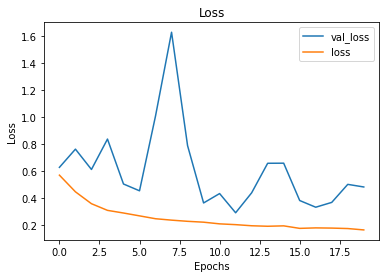

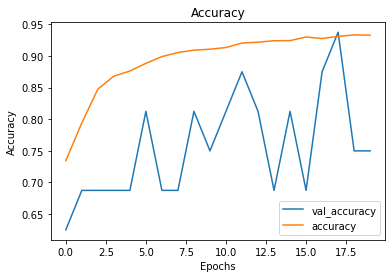

In [235]:
# Plot accuracy and loss
visualize_training_results(history_2)

## Model 3 Iteration Added Layers, Adam optimizer, Padding Model and Strides

In [236]:
#Instantiate a CNN model

model_3 = Sequential()

# Add convolution layer

model_3.add(Conv2D(32, (3, 3), padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (64, 64, 3)))

# Add a maxpooling layer

model_3.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same'))


model_3.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

model_3.add(Conv2D(128, (3, 3), padding = 'same', strides = 2, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

model_3.add(Conv2D(256, (3, 3), padding = 'same', strides = 2, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

# Flatten the model

model_3.add(Flatten())

# Add dense layers, two hidden

model_3.add(Dense(64, activation = 'relu'))
model_3.add(Dense(7, activation = 'relu'))
model_3.add(Dense(5, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_3.add(Dense(1))
model_3.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [237]:
model_3.summary()


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 8, 8, 256)       

In [249]:
history_3 = model_3.fit(train_generator,  
                      epochs=20, 
                      validation_data=val_generator,
                      verbose = 1) 
                      

Epoch 1/20
163/163 [==============================] - 70s 432ms/step - loss: 0.1460 - accuracy: 0.9431 - val_loss: 0.2622 - val_accuracy: 0.8125
Epoch 2/20
163/163 [==============================] - 70s 428ms/step - loss: 0.1627 - accuracy: 0.9335 - val_loss: 1.2104 - val_accuracy: 0.5625
Epoch 3/20
163/163 [==============================] - 69s 425ms/step - loss: 0.1451 - accuracy: 0.9456 - val_loss: 0.4097 - val_accuracy: 0.8750
Epoch 4/20
163/163 [==============================] - 71s 433ms/step - loss: 0.1424 - accuracy: 0.9431 - val_loss: 0.9907 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 70s 432ms/step - loss: 0.1502 - accuracy: 0.9398 - val_loss: 0.7796 - val_accuracy: 0.7500
Epoch 6/20
163/163 [==============================] - 70s 430ms/step - loss: 0.1325 - accuracy: 0.9507 - val_loss: 0.4874 - val_accuracy: 0.7500
Epoch 7/20
163/163 [==============================] - 70s 430ms/step - loss: 0.1359 - accuracy: 0.9469 - val_loss: 0.7064 - val_ac

In [250]:
results_3_train = model_3.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 912us/step - loss: 0.2955 - accuracy: 0.9375


In [251]:
results_3_test = model_3.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 2ms/step - loss: 1.0857 - accuracy: 0.7188


In [252]:
#Print results for Model 1 train and test
print("Model 3 Results from Training Data:", results_3_train)
print()
print("Model 3 Results from Test Data:", results_3_test)


Model 3 Results from Training Data: [0.2954646944999695, 0.9375]

Model 3 Results from Test Data: [1.0856742858886719, 0.71875]


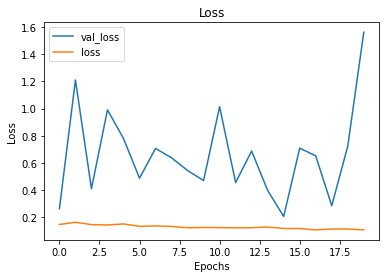

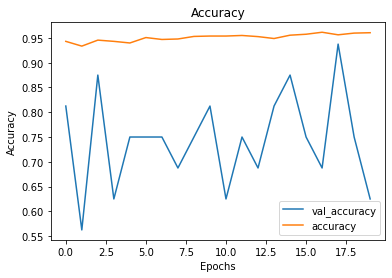

In [253]:
# Plot accuracy and loss
visualize_training_results(history_3)

## Final model with added layering and regularization (L1/L2/dropouts)


In [254]:
#Instantiate a CNN model

model_4 = Sequential()

# Add convolution layer with alternating strides

model_4.add(Conv2D(32, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (64, 64, 3)))

# Add a maxpooling layer

model_4.add(MaxPooling2D(pool_size=(2, 2), padding = 'same', strides = 2))

#Add a dropout

model_4.add(Dropout(0.1))

model_4.add(Conv2D(32, (3, 3), padding = 'same', strides = 1,  
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_4.add(Dropout(0.1))

model_4.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.005), 
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_4.add(Dropout(0.1))

model_4.add(Conv2D(128, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_4.add(Dropout(0.1))
model_4.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

# Flatten the model

model_4.add(Flatten())

# Add dense layers, two hidden

model_4.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.005), activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [255]:
model_4.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 16, 16, 64)      

In [265]:
history_4 = model_4.fit(train_generator, 
                       epochs = 20)

Epoch 1/20
163/163 [==============================] - 66s 403ms/step - loss: 0.4873 - accuracy: 0.8066
Epoch 2/20
163/163 [==============================] - 66s 406ms/step - loss: 0.4664 - accuracy: 0.8104
Epoch 3/20
163/163 [==============================] - 65s 401ms/step - loss: 0.4551 - accuracy: 0.8175
Epoch 4/20
163/163 [==============================] - 67s 411ms/step - loss: 0.4387 - accuracy: 0.8288
Epoch 5/20
163/163 [==============================] - 62s 381ms/step - loss: 0.4135 - accuracy: 0.8451
Epoch 6/20
163/163 [==============================] - 64s 391ms/step - loss: 0.3986 - accuracy: 0.8503
Epoch 7/20
163/163 [==============================] - 65s 402ms/step - loss: 0.3871 - accuracy: 0.8524
Epoch 8/20
163/163 [==============================] - 66s 405ms/step - loss: 0.3796 - accuracy: 0.8570
Epoch 9/20
163/163 [==============================] - 65s 397ms/step - loss: 0.3924 - accuracy: 0.8464
Epoch 10/20
163/163 [==============================] - 66s 406ms/step - l

In [266]:
results_4_train = model_4.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 6ms/step - loss: 0.3265 - accuracy: 0.8750


In [272]:
results_4_test = model_4.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 911us/step - loss: 0.3609 - accuracy: 0.8125


In [268]:
visualize_training_results(history_4)

KeyError: 'val_loss'

<Figure size 432x288 with 0 Axes>

In [271]:
history_4

#### Correct for underfitting results 

In [260]:
#Instantiate a CNN model

model_4 = Sequential()

# Apply 2 Convolution with Maxpooling and Dropouts Layers

model_4.add(Conv2D(32, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (64, 64, 3)))

model_4.add(MaxPooling2D(pool_size=(2, 2), padding = 'same', strides = 2))
model_4.add(Dropout(0.1))



model_4.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), padding = 'same', strides = 2))
model_4.add(Dropout(0.1))


# Flatten the model

model_4.add(Flatten())

# Add dense layers, two hidden

model_4.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.005), activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [262]:
model_4.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 16384)           

In [ ]:
results_5 = model_4.fit(train_datagen, 
                       epochs = 30)

## Evaluate Final Model

In [70]:
# Create 

In [193]:

#model_1.save_weights('model_1.h5')

In [104]:
predictions = np.argmax(model_1.predict_classes(test_generator), axis =1)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#plot confusion matrix

In [ ]:
#

In [1]:
import seaborn as sns

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test)
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val)
plt.title('Validation data')

plt.show();

NameError: name 'plt' is not defined

In [ ]:
datagen = ImageDataGenerator

44
